<img src="https://www.microsoft.com/en-us/research/uploads/prod/2020/05/Segmentation.png" width="400"/>

# Customer Segmentation: Estimate Individualized Responses to Incentives

Nowadays, business decision makers rely on estimating the causal effect of interventions to answer what-if questions about shifts in strategy, such as promoting specific product with discount, adding new features to a website or increasing investment from a sales team. However, rather than learning whether to take action for a specific intervention for all users, people are increasingly interested in understanding the different responses from different users to the two alternatives. Identifying the characteristics of users having the strongest response for the intervention could help make rules to segment the future users into different groups. This can help optimize the policy to use the least resources and get the most profit.

In this case study, we will use a personalized pricing example to explain how the [EconML](https://aka.ms/econml) library could fit into this problem and provide robust and reliable causal solutions.

### Summary

1. [Background](#background)
2. [Data](#data)
3. [Get Causal Effects with EconML](#estimate)
4. [Understand Treatment Effects with EconML](#interpret)
5. [Make Policy Decisions with EconML](#policy)
6. [Conclusions](#conclusion)


# Background <a id="background"></a>

<img src="https://cdn.pixabay.com/photo/2018/08/16/11/59/radio-3610287_960_720.png" width="400" />

The global online media market is growing fast over the years. Media companies are always interested in attracting more users into the market and encouraging them to buy more songs or become members. In this example, we'll consider a scenario where one experiment a media company is running is to give small discount (10%, 20% or 0) to their current users based on their income level in order to boost the likelihood of their purchase. The goal is to understand the **heterogeneous price elasticity of demand** for people with different income level, learning which users would respond most strongly to a small discount. Furthermore, their end goal is to make sure that despite decreasing the price for some consumers, the demand is raised enough to boost the overall revenue.

EconML’s `DML` based estimators can be used to take the discount variation in existing data, along with a rich set of user features, to estimate heterogeneous price sensitivities that vary with multiple customer features. Then, the `SingleTreeCateInterpreter` provides a presentation-ready summary of the key features that explain the biggest differences in responsiveness to a discount, and the `SingleTreePolicyInterpreter` recommends a policy on who should receive a discount in order to increase revenue (not only demand), which could help the company to set an optimal price for those users in the future. 

In [1]:
# Some imports to get us started
# Utilities
import os
import urllib.request
import numpy as np
import pandas as pd

# Generic ML imports
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor

# EconML imports
from econml.dml import LinearDML, CausalForestDML
from econml.cate_interpreter import SingleTreeCateInterpreter, SingleTreePolicyInterpreter

import matplotlib.pyplot as plt

%matplotlib inline

# Data <a id="data"></a>


The dataset* has ~10,000 observations and includes 9 continuous and categorical variables that represent user's characteristics and online behaviour history such as age, log income, previous purchase, previous online time per week, etc. 

We define the following variables:

Feature Name|Type|Details 
:--- |:---|:--- 
**account_age** |W| user's account age
**age** |W|user's age
**avg_hours** |W| the average hours user was online per week in the past
**days_visited** |W| the average number of days user visited the website per week in the past
**friend_count** |W| number of friends user connected in the account 
**has_membership** |W| whether the user had membership
**is_US** |W| whether the user accesses the website from the US 
**songs_purchased** |W| the average songs user purchased per week in the past
**income** |X| user's income
**price** |T| the price user was exposed during the discount season (baseline price * small discount)
**demand** |Y| songs user purchased during the discount season

**To protect the privacy of the company, we use the simulated data as an example here. The data is synthetically generated and the feature distributions don't correspond to real distributions. However, the feature names have preserved their names and meaning.*


The treatment and outcome are generated using the following functions:
$$
T = 
\begin{cases}
  1 & \text{with } p=0.2,  \\
  0.9 & \text{with }p=0.3, & \text{if income}<1 \\
  0.8 & \text{with }p=0.5, \\
  \\
    1 & \text{with }p=0.7, \\
  0.9 & \text{with }p=0.2, & \text{if income}\ge1 \\
  0.8 & \text{with }p=0.1, \\
\end{cases}
$$


\begin{align}
\gamma(X) & = -3 - 14 \cdot \{\text{income}<1\} \\
\beta(X,W) & = 20 + 0.5 \cdot \text{avg_hours} + 5 \cdot \{\text{days_visited}>4\} \\
Y &= \gamma(X) \cdot T + \beta(X,W)
\end{align}



In [2]:
# Import the sample pricing data
file_url = "https://msalicedatapublic.blob.core.windows.net/datasets/Pricing/pricing_sample.csv"
train_data = pd.read_csv(file_url)

In [3]:
# Data sample
train_data.head()

,account_age,age,avg_hours,days_visited,friends_count,has_membership,is_US,songs_purchased,income,price,demand
0,3,53,1.834234,2,8,1,1,4.903237,0.960863,1.0,3.917117
1,5,54,7.171411,7,9,0,1,3.330161,0.732487,1.0,11.585706
2,3,33,5.351920,6,9,0,1,3.036203,1.130937,1.0,24.675960
3,2,34,6.723551,0,8,0,1,7.911926,0.929197,1.0,6.361776
4,4,30,2.448247,5,8,1,0,7.148967,0.533527,0.8,12.624123


In [4]:
# Define estimator inputs
Y = train_data["demand"]  # outcome of interest
T = train_data["price"]  # intervention, or treatment
X = train_data[["income"]]  # features
W = train_data.drop(columns=["demand", "price", "income"])  # confounders

In [5]:
# Get test data
X_test = np.linspace(0, 5, 100).reshape(-1, 1)
X_test_data = pd.DataFrame(X_test, columns=["income"])

# Get Causal Effects with EconML <a id="estimate"></a>
To learn the price elasticity on demand as a function of income, we fit the model as follows:


\begin{align}
log(Y) & = \theta(X) \cdot log(T) + f(X,W) + \epsilon \\
log(T) & = g(X,W) + \eta
\end{align}


where $\epsilon, \eta$ are uncorrelated error terms. 

The models we fit here aren't an exact match for the data generation function above, but if they are a good approximation, they will allow us to create a good discount policy.  Although the model is misspecified, we hope to see that our `DML` based estimators can still capture the right trend of $\theta(X)$ and that the recommended policy beats other baseline policies (such as always giving a discount) on revenue.  Because of the mismatch between the data generating process and the model we're fitting, there isn't a single true $\theta(X)$ (the true elasticity varies with not only X but also T and W), but given how we generate the data above, we can still calculate the range of true $\theta(X)$ to compare against.

In [6]:
# Define underlying treatment effect function given DGP
def gamma_fn(X):
    return -3 - 14 * (X["income"] < 1)

def beta_fn(X):
    return 20 + 0.5 * (X["avg_hours"]) + 5 * (X["days_visited"] > 4)

def demand_fn(data, T):
    Y = gamma_fn(data) * T + beta_fn(data)
    return Y

def true_te(x, n, stats):
    if x < 1:
        subdata = train_data[train_data["income"] < 1].sample(n=n, replace=True)
    else:
        subdata = train_data[train_data["income"] >= 1].sample(n=n, replace=True)
    te_array = subdata["price"] * gamma_fn(subdata) / (subdata["demand"])
    if stats == "mean":
        return np.mean(te_array)
    elif stats == "median":
        return np.median(te_array)
    elif isinstance(stats, int):
        return np.percentile(te_array, stats)

In [7]:
# Get the estimate and range of true treatment effect
truth_te_estimate = np.apply_along_axis(true_te, 1, X_test, 1000, "mean")  # estimate
truth_te_upper = np.apply_along_axis(true_te, 1, X_test, 1000, 95)  # upper level
truth_te_lower = np.apply_along_axis(true_te, 1, X_test, 1000, 5)  # lower level

## Parametric heterogeneity
First of all, we can try to learn a **linear projection of the treatment effect** assuming a polynomial form of $\theta(X)$. We use the `LinearDML` estimator. Since we don't have any priors on these models, we use a generic gradient boosting tree estimators to learn the expected price and demand from the data.

In [8]:
# Get log_T and log_Y
log_T = np.log(T)
log_Y = np.log(Y)

In [9]:
# Train EconML model
est = LinearDML(
    model_y=GradientBoostingRegressor(),
    model_t=GradientBoostingRegressor(),
    featurizer=PolynomialFeatures(degree=2, include_bias=False),
)
est.fit(log_Y, log_T, X=X, W=W, inference="statsmodels")
# Get treatment effect and its confidence interval
te_pred = est.effect(X_test)
te_pred_interval = est.effect_interval(X_test)

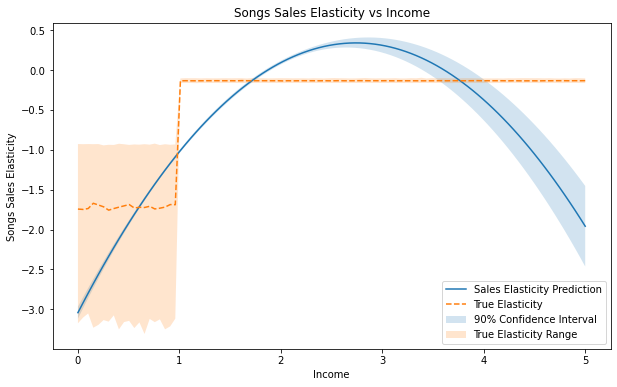

In [10]:
# Compare the estimate and the truth
plt.figure(figsize=(10, 6))
plt.plot(X_test.flatten(), te_pred, label="Sales Elasticity Prediction")
plt.plot(X_test.flatten(), truth_te_estimate, "--", label="True Elasticity")
plt.fill_between(
    X_test.flatten(),
    te_pred_interval[0],
    te_pred_interval[1],
    alpha=0.2,
    label="90% Confidence Interval",
)
plt.fill_between(
    X_test.flatten(),
    truth_te_lower,
    truth_te_upper,
    alpha=0.2,
    label="True Elasticity Range",
)
plt.xlabel("Income")
plt.ylabel("Songs Sales Elasticity")
plt.title("Songs Sales Elasticity vs Income")
plt.legend(loc="lower right")

From the plot above, it's clear to see that the true treatment effect is a **nonlinear** function of income, with elasticity around -1.75 when income is smaller than 1 and a small negative value when income is larger than 1. The model fits a quadratic treatment effect, which is not a great fit. But it still captures the overall trend: the elasticity is negative and people are less sensitive to the price change if they have higher income.

In [11]:
# Get the final coefficient and intercept summary
est.summary()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
income,2.467,0.073,33.765,0.0,2.347,2.587
income^2,-0.45,0.025,-18.147,0.0,-0.491,-0.409
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,-3.041,0.046,-66.745,0.0,-3.116,-2.967


`LinearDML` estimator can also return the summary of the coefficients and intercept for the final model, including point estimates, p-values and confidence intervals. From the table above, we notice that $income$ has positive effect and ${income}^2$ has negative effect, and both of them are statistically significant.

## Nonparametric Heterogeneity
Since we already know the true treatment effect function is nonlinear, let us fit another model using `CausalForestDML`, which assumes a fully **nonparametric estimation of the treatment effect**.

In [12]:
# Train EconML model
est = CausalForestDML(
    model_y=GradientBoostingRegressor(), model_t=GradientBoostingRegressor()
)
est.fit(log_Y, log_T, X=X, W=W, inference="blb")
# Get treatment effect and its confidence interval
te_pred = est.effect(X_test)
te_pred_interval = est.effect_interval(X_test)

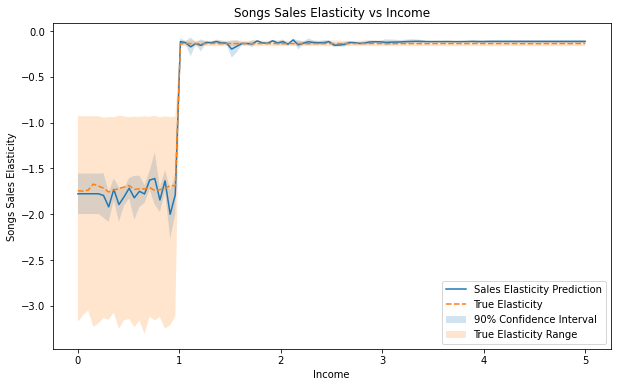

In [13]:
# Compare the estimate and the truth
plt.figure(figsize=(10, 6))
plt.plot(X_test.flatten(), te_pred, label="Sales Elasticity Prediction")
plt.plot(X_test.flatten(), truth_te_estimate, "--", label="True Elasticity")
plt.fill_between(
    X_test.flatten(),
    te_pred_interval[0],
    te_pred_interval[1],
    alpha=0.2,
    label="90% Confidence Interval",
)
plt.fill_between(
    X_test.flatten(),
    truth_te_lower,
    truth_te_upper,
    alpha=0.2,
    label="True Elasticity Range",
)
plt.xlabel("Income")
plt.ylabel("Songs Sales Elasticity")
plt.title("Songs Sales Elasticity vs Income")
plt.legend(loc="lower right")

We notice that this model fits much better than the `LinearDML`, the 90% confidence interval correctly covers the true treatment effect estimate and captures the variation when income is around 1. Overall, the model shows that people with low income are much more sensitive to the price changes than higher income people.

# Understand Treatment Effects with EconML <a id="interpret"></a>
EconML includes interpretability tools to better understand treatment effects. Treatment effects can be complex, but oftentimes we are interested in simple rules that can differentiate between users who respond positively, users who remain neutral and users who respond negatively to the proposed changes.

The EconML `SingleTreeCateInterpreter` provides interperetability by training a single decision tree on the treatment effects outputted by any of the EconML estimators. In the figure below we can see in dark red users respond strongly to the discount and the in white users respond lightly to the discount.

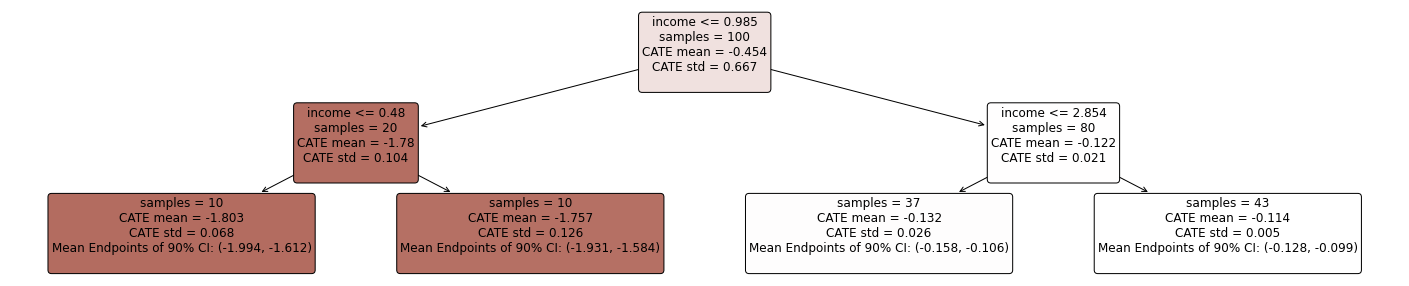

In [14]:
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2, min_samples_leaf=10)
intrp.interpret(est, X_test)
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=X.columns, fontsize=12)

# Make Policy Decision with EconML <a id="policy"></a>
We want to make policy decisions to maximum the **revenue** instead of the demand. In this scenario,


\begin{align}
Rev & = Y \cdot T \\
    & = \exp^{log(Y)} \cdot T\\
    & = \exp^{(\theta(X) \cdot log(T) + f(X,W) + \epsilon)} \cdot T \\
    & = \exp^{(f(X,W) + \epsilon)} \cdot T^{(\theta(X)+1)}
\end{align}


With the decrease of price, revenue will increase only if $\theta(X)+1<0$. Thus, we set `sample_treatment_cast=-1` here to learn **what kinds of customers we should give a small discount to maximum the revenue**.

The EconML library includes policy interpretability tools such as `SingleTreePolicyInterpreter` that take in a treatment cost and the treatment effects to learn simple rules about which customers to target profitably. In the figure below we can see the model recommends to give discount for people with income less than $0.985$ and give original price for the others.

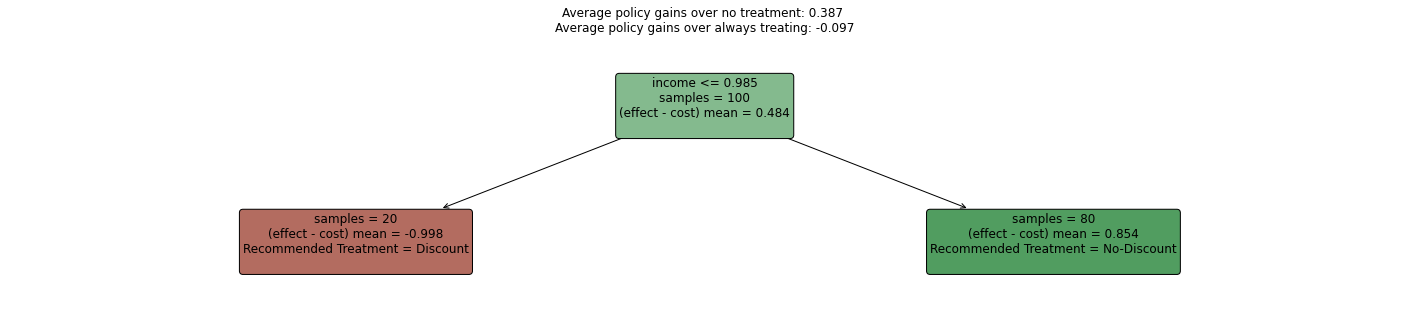

In [15]:
intrp = SingleTreePolicyInterpreter(risk_level=0.05, max_depth=2, min_samples_leaf=1, min_impurity_decrease=0.001)
intrp.interpret(est, X_test, sample_treatment_costs=-1, treatment_names=["Discount", "No-Discount"])
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=X.columns, fontsize=12)

Now, let us compare our policy with other baseline policies! Our model says which customers to give a small discount to, and for this experiment, we will set a discount level of 10% for those users. Because the model is misspecified we would not expect good results with large discounts. Here, because we know the ground truth, we can evaluate the value of this policy.

In [16]:
# define function to compute revenue
def revenue_fn(data, discount_level1, discount_level2, baseline_T, policy):
    policy_price = baseline_T * (1 - discount_level1) * policy + baseline_T * (1 - discount_level2) * (1 - policy)
    demand = demand_fn(data, policy_price)
    rev = demand * policy_price
    return rev

In [17]:
policy_dic = {}
# our policy above
policy = intrp.treat(X)
policy_dic["Our Policy"] = np.mean(revenue_fn(train_data, 0, 0.1, 1, policy))

## previous strategy
policy_dic["Previous Strategy"] = np.mean(train_data["price"] * train_data["demand"])

## give everyone discount
policy_dic["Give Everyone Discount"] = np.mean(revenue_fn(train_data, 0.1, 0, 1, np.ones(len(X))))

## don't give discount
policy_dic["Give No One Discount"] = np.mean(revenue_fn(train_data, 0, 0.1, 1, np.ones(len(X))))

## follow our policy, but give -10% discount for the group doesn't recommend to give discount
policy_dic["Our Policy + Give Negative Discount for No-Discount Group"] = np.mean(revenue_fn(train_data, -0.1, 0.1, 1, policy))

## give everyone -10% discount
policy_dic["Give Everyone Negative Discount"] = np.mean(revenue_fn(train_data, -0.1, 0, 1, np.ones(len(X))))

In [18]:
# get policy summary table
res = pd.DataFrame.from_dict(policy_dic, orient="index", columns=["Revenue"])
res["Rank"] = res["Revenue"].rank(ascending=False)
res

,Revenue,Rank
Our Policy,14.686241,2.0
Previous Strategy,14.349342,4.0
Give Everyone Discount,13.774469,6.0
Give No One Discount,14.294606,5.0
Our Policy + Give Negative Discount for No-Discount Group,15.564411,1.0
Give Everyone Negative Discount,14.612670,3.0


**We beat the baseline policies!** Our policy gets the highest revenue except for the one raising the price for the No-Discount group. That means our currently baseline price is low, but the way we segment the user does help increase the revenue!

# Conclusions <a id="conclusion"></a>

In this notebook, we have demonstrated the power of using EconML to:

* Estimate the treatment effect correctly even the model is misspecified
* Interpret the resulting individual-level treatment effects
* Make the policy decision beats the previous and baseline policies

To learn more about what EconML can do for you, visit our [website](https://aka.ms/econml), our [GitHub page](https://github.com/microsoft/EconML) or our [documentation](https://econml.azurewebsites.net/). 